In [22]:
import sys
sys.path.insert(0, '../../pyLDLE2/')

import torch
import torch.nn
import torch.optim

import GraphX as gx
import ConnectionGraphX as cgx
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix
from scipy.linalg import pinv

import ConnectionNetworkX_v2 as cnx

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from pyLDLE2 import datasets, visualize_

In [160]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX_v2' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/ConnectionNetworkX_v2.py'>

# Load torus data

In [24]:
X, labelsMat, _ = datasets.Datasets().curvedtorus3d(n=1000)

X.shape =  (1000, 3)


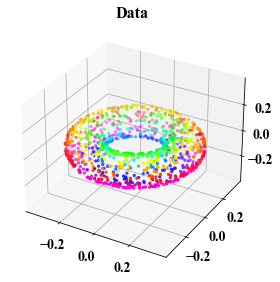

In [25]:
%matplotlib inline
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

In [29]:
from scipy.spatial.distance import pdist, squareform
d_e = squareform(pdist(X))

In [30]:
np.sort(d_e[0,:])

array([0.        , 0.01642311, 0.02087277, 0.0214407 , 0.03037262,
       0.0321225 , 0.03604526, 0.03922174, 0.04131797, 0.04318747,
       0.0467219 , 0.04861545, 0.05173357, 0.06013023, 0.06425038,
       0.07121258, 0.07543424, 0.07544031, 0.08238531, 0.09113231,
       0.09126772, 0.09201367, 0.09304847, 0.0939471 , 0.09494795,
       0.09556682, 0.09566389, 0.09597515, 0.09778438, 0.09849945,
       0.09881892, 0.09979089, 0.1013242 , 0.10162664, 0.10399735,
       0.10544094, 0.10552547, 0.10557152, 0.10795288, 0.10945425,
       0.11034791, 0.11078323, 0.11211687, 0.11401986, 0.11407034,
       0.11602049, 0.11827233, 0.11869741, 0.11887563, 0.11948675,
       0.11954218, 0.12022796, 0.12052079, 0.12092676, 0.12110801,
       0.121274  , 0.12259276, 0.12294355, 0.12313265, 0.12376973,
       0.12389303, 0.12514713, 0.12574094, 0.12716711, 0.12760602,
       0.13102887, 0.13306451, 0.13429854, 0.13438597, 0.13911725,
       0.13917191, 0.13947328, 0.14293689, 0.14349038, 0.14356

#  build connection graph

In [162]:
NEAREST_NEIGHBORS = 28
INTRINSIC_DIMENSION = 2

#CG = cnx.cnxFromData(X, k=NEAREST_NEIGHBORS, d=INTRINSIC_DIMENSION)
CG = cnx.cnxFromData_v2(X, 0.075, 0.1, d=INTRINSIC_DIMENSION, tol=0.35)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1266.35it/s]


Proportion of edges which were removed due to remoteness:  0.6176887519260401
[-0.05243796 -0.04424652 -0.01435343  0.01273883  0.06343017  0.07514505
  0.09466814  0.11755934  0.12418403  0.14407397]
MOST LIKELY INCONSISTENT: |lambda_min| >= 1e-8. 


# Set B, w, mu, nu, c

In [163]:
d = INTRINSIC_DIMENSION
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
W = np.ones(B.shape[0]//d).astype('float32')

np.random.seed(42)
source = np.random.randint(0, CG.number_of_nodes())
dest = np.random.randint(0, CG.number_of_nodes())

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = 1
nu[dest * d: (dest + 1) * d, :] = 1

c = (mu - nu)

In [164]:
B.T.shape

(2000, 12406)

In [165]:
c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)

# I didn't rename the dummy variables here- caution.

np.linalg.norm(c.flatten() - B.T.dot(c_sol).flatten())

/tmp/ipykernel_13740/426106341.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)


1.1639986996081127e-14

In [166]:
learning_rate = 0.001
alpha = 1
n_epochs = 10000

B_torch = torch.tensor(B.toarray().astype('float32'))
w_torch = torch.tensor(W.astype('float32'))
c_torch = torch.tensor(c.astype('float32'))
phi0 = -pinv(B.T.dot(B).toarray()).dot(c).astype('float32')
#phi0 = None

if phi0 is not None:
    print('Initial loss:', cnx.loss_fn(torch.tensor(phi0), B_torch, w_torch, c_torch))

phi = cnx.optimize(B_torch, w_torch, c_torch, alpha, learning_rate, n_epochs, phi0 = phi0).detach().numpy()
#phi = phi0

Initial loss: (tensor(0.6318), tensor(0.))
epoch: 0, loss: 0.631817, loss0: 0.631817, loss1: 0.000000
epoch: 10, loss: 0.591817, loss0: 0.591817, loss1: 0.000000
epoch: 20, loss: 0.551817, loss0: 0.551817, loss1: 0.000000
epoch: 30, loss: 0.511817, loss0: 0.511817, loss1: 0.000000
epoch: 40, loss: 0.471817, loss0: 0.471817, loss1: 0.000000
epoch: 50, loss: 0.431817, loss0: 0.431817, loss1: 0.000000
epoch: 60, loss: 0.391817, loss0: 0.391817, loss1: 0.000000
epoch: 70, loss: 0.351817, loss0: 0.351817, loss1: 0.000000
epoch: 80, loss: 0.311816, loss0: 0.311816, loss1: 0.000000
epoch: 90, loss: 0.271816, loss0: 0.271816, loss1: 0.000000
epoch: 100, loss: 0.231816, loss0: 0.231816, loss1: 0.000000
epoch: 110, loss: 0.191816, loss0: 0.191816, loss1: 0.000000
epoch: 120, loss: 0.151816, loss0: 0.151816, loss1: 0.000000
epoch: 130, loss: 0.111816, loss0: 0.111816, loss1: 0.000000
epoch: 140, loss: 0.071816, loss0: 0.071816, loss1: 0.000000
epoch: 150, loss: 0.031816, loss0: 0.031816, loss1: 0

epoch: 1300, loss: -4.566619, loss0: -4.566650, loss1: 0.000062
epoch: 1310, loss: -4.606517, loss0: -4.606554, loss1: 0.000073
epoch: 1320, loss: -4.646409, loss0: -4.646451, loss1: 0.000085
epoch: 1330, loss: -4.686291, loss0: -4.686341, loss1: 0.000100
epoch: 1340, loss: -4.726166, loss0: -4.726223, loss1: 0.000113
epoch: 1350, loss: -4.766035, loss0: -4.766098, loss1: 0.000127
epoch: 1360, loss: -4.805898, loss0: -4.805966, loss1: 0.000137
epoch: 1370, loss: -4.845757, loss0: -4.845830, loss1: 0.000146
epoch: 1380, loss: -4.885611, loss0: -4.885689, loss1: 0.000156
epoch: 1390, loss: -4.925461, loss0: -4.925543, loss1: 0.000165
epoch: 1400, loss: -4.965305, loss0: -4.965394, loss1: 0.000178
epoch: 1410, loss: -5.005144, loss0: -5.005240, loss1: 0.000192
epoch: 1420, loss: -5.044978, loss0: -5.045082, loss1: 0.000207
epoch: 1430, loss: -5.084807, loss0: -5.084918, loss1: 0.000221
epoch: 1440, loss: -5.124628, loss0: -5.124749, loss1: 0.000243
epoch: 1450, loss: -5.164439, loss0: -5.

epoch: 2650, loss: -9.559751, loss0: -9.695923, loss1: 0.272344
epoch: 2660, loss: -9.586232, loss0: -9.727791, loss1: 0.283117
epoch: 2670, loss: -9.612426, loss0: -9.759464, loss1: 0.294077
epoch: 2680, loss: -9.638314, loss0: -9.790943, loss1: 0.305258
epoch: 2690, loss: -9.663901, loss0: -9.822220, loss1: 0.316637
epoch: 2700, loss: -9.689178, loss0: -9.853293, loss1: 0.328231
epoch: 2710, loss: -9.714139, loss0: -9.884160, loss1: 0.340042
epoch: 2720, loss: -9.738831, loss0: -9.914816, loss1: 0.351972
epoch: 2730, loss: -9.763240, loss0: -9.945263, loss1: 0.364047
epoch: 2740, loss: -9.787375, loss0: -9.975494, loss1: 0.376238
epoch: 2750, loss: -9.811240, loss0: -10.005518, loss1: 0.388556
epoch: 2760, loss: -9.834829, loss0: -10.035336, loss1: 0.401013
epoch: 2770, loss: -9.858145, loss0: -10.064941, loss1: 0.413592
epoch: 2780, loss: -9.881161, loss0: -10.094336, loss1: 0.426349
epoch: 2790, loss: -9.903892, loss0: -10.123510, loss1: 0.439237
epoch: 2800, loss: -9.926360, loss0

epoch: 3900, loss: -11.512188, loss0: -12.200386, loss1: 1.376397
epoch: 3910, loss: -11.522913, loss0: -12.212403, loss1: 1.378981
epoch: 3920, loss: -11.533595, loss0: -12.224358, loss1: 1.381526
epoch: 3930, loss: -11.544240, loss0: -12.236243, loss1: 1.384007
epoch: 3940, loss: -11.554841, loss0: -12.248064, loss1: 1.386446
epoch: 3950, loss: -11.565399, loss0: -12.259833, loss1: 1.388869
epoch: 3960, loss: -11.575925, loss0: -12.271557, loss1: 1.391264
epoch: 3970, loss: -11.586418, loss0: -12.283234, loss1: 1.393631
epoch: 3980, loss: -11.596875, loss0: -12.294857, loss1: 1.395964
epoch: 3990, loss: -11.607296, loss0: -12.306425, loss1: 1.398257
epoch: 4000, loss: -11.617689, loss0: -12.317947, loss1: 1.400517
epoch: 4010, loss: -11.628048, loss0: -12.329421, loss1: 1.402746
epoch: 4020, loss: -11.638371, loss0: -12.340849, loss1: 1.404957
epoch: 4030, loss: -11.648650, loss0: -12.352226, loss1: 1.407152
epoch: 4040, loss: -11.658888, loss0: -12.363550, loss1: 1.409325
epoch: 405

epoch: 5160, loss: -12.445319, loss0: -13.267838, loss1: 1.645037
epoch: 5170, loss: -12.448545, loss0: -13.272223, loss1: 1.647355
epoch: 5180, loss: -12.451715, loss0: -13.276550, loss1: 1.649672
epoch: 5190, loss: -12.454825, loss0: -13.280819, loss1: 1.651987
epoch: 5200, loss: -12.457875, loss0: -13.285023, loss1: 1.654295
epoch: 5210, loss: -12.460868, loss0: -13.289167, loss1: 1.656599
epoch: 5220, loss: -12.463801, loss0: -13.293253, loss1: 1.658904
epoch: 5230, loss: -12.466681, loss0: -13.297281, loss1: 1.661201
epoch: 5240, loss: -12.469503, loss0: -13.301249, loss1: 1.663491
epoch: 5250, loss: -12.472270, loss0: -13.305156, loss1: 1.665771
epoch: 5260, loss: -12.474984, loss0: -13.308996, loss1: 1.668024
epoch: 5270, loss: -12.477645, loss0: -13.312775, loss1: 1.670260
epoch: 5280, loss: -12.480248, loss0: -13.316489, loss1: 1.672482
epoch: 5290, loss: -12.482801, loss0: -13.320142, loss1: 1.674681
epoch: 5300, loss: -12.485299, loss0: -13.323736, loss1: 1.676875
epoch: 531

epoch: 6420, loss: -12.574429, loss0: -13.493311, loss1: 1.837765
epoch: 6430, loss: -12.574484, loss0: -13.493600, loss1: 1.838232
epoch: 6440, loss: -12.574539, loss0: -13.493882, loss1: 1.838686
epoch: 6450, loss: -12.574591, loss0: -13.494154, loss1: 1.839127
epoch: 6460, loss: -12.574638, loss0: -13.494417, loss1: 1.839557
epoch: 6470, loss: -12.574686, loss0: -13.494672, loss1: 1.839972
epoch: 6480, loss: -12.574734, loss0: -13.494921, loss1: 1.840374
epoch: 6490, loss: -12.574776, loss0: -13.495158, loss1: 1.840766
epoch: 6500, loss: -12.574816, loss0: -13.495391, loss1: 1.841150
epoch: 6510, loss: -12.574855, loss0: -13.495616, loss1: 1.841523
epoch: 6520, loss: -12.574893, loss0: -13.495834, loss1: 1.841883
epoch: 6530, loss: -12.574928, loss0: -13.496046, loss1: 1.842236
epoch: 6540, loss: -12.574963, loss0: -13.496253, loss1: 1.842581
epoch: 6550, loss: -12.574993, loss0: -13.496456, loss1: 1.842926
epoch: 6560, loss: -12.575026, loss0: -13.496653, loss1: 1.843253
epoch: 657

epoch: 7670, loss: -12.575625, loss0: -13.502493, loss1: 1.853735
epoch: 7680, loss: -12.575624, loss0: -13.502495, loss1: 1.853740
epoch: 7690, loss: -12.575626, loss0: -13.502496, loss1: 1.853740
epoch: 7700, loss: -12.575627, loss0: -13.502501, loss1: 1.853746
epoch: 7710, loss: -12.575624, loss0: -13.502504, loss1: 1.853760
epoch: 7720, loss: -12.575628, loss0: -13.502507, loss1: 1.853758
epoch: 7730, loss: -12.575627, loss0: -13.502506, loss1: 1.853757
epoch: 7740, loss: -12.575627, loss0: -13.502508, loss1: 1.853762
epoch: 7750, loss: -12.575627, loss0: -13.502510, loss1: 1.853766
epoch: 7760, loss: -12.575628, loss0: -13.502514, loss1: 1.853770
epoch: 7770, loss: -12.575628, loss0: -13.502518, loss1: 1.853779
epoch: 7780, loss: -12.575627, loss0: -13.502518, loss1: 1.853780
epoch: 7790, loss: -12.575628, loss0: -13.502518, loss1: 1.853780
epoch: 7800, loss: -12.575629, loss0: -13.502520, loss1: 1.853781
epoch: 7810, loss: -12.575628, loss0: -13.502520, loss1: 1.853784
epoch: 782

epoch: 8930, loss: -12.575636, loss0: -13.502570, loss1: 1.853869
epoch: 8940, loss: -12.575633, loss0: -13.502573, loss1: 1.853879
epoch: 8950, loss: -12.575636, loss0: -13.502577, loss1: 1.853882
epoch: 8960, loss: -12.575636, loss0: -13.502576, loss1: 1.853880
epoch: 8970, loss: -12.575636, loss0: -13.502579, loss1: 1.853886
epoch: 8980, loss: -12.575637, loss0: -13.502580, loss1: 1.853886
epoch: 8990, loss: -12.575635, loss0: -13.502581, loss1: 1.853891
epoch: 9000, loss: -12.575637, loss0: -13.502573, loss1: 1.853872
epoch: 9010, loss: -12.575636, loss0: -13.502577, loss1: 1.853882
epoch: 9020, loss: -12.575636, loss0: -13.502581, loss1: 1.853890
epoch: 9030, loss: -12.575634, loss0: -13.502586, loss1: 1.853904
epoch: 9040, loss: -12.575636, loss0: -13.502583, loss1: 1.853893
epoch: 9050, loss: -12.575635, loss0: -13.502584, loss1: 1.853898
epoch: 9060, loss: -12.575636, loss0: -13.502584, loss1: 1.853895
epoch: 9070, loss: -12.575636, loss0: -13.502584, loss1: 1.853896
epoch: 908

In [167]:
edge_score = cnx.active_edges(torch.tensor(phi), B_torch, w_torch, c_torch)
#edge_score = nabla_phi_norm(phi, B)
edge_score = edge_score.detach().numpy()

In [168]:
J_opt = cnx.optimal_J(torch.tensor(phi), B_torch, w_torch, alpha, d).detach().numpy()

In [169]:
err = B.T.dot(J_opt.flatten()[:,None]) - c

In [170]:
np.mean(np.abs(err))

0.004072333358449441

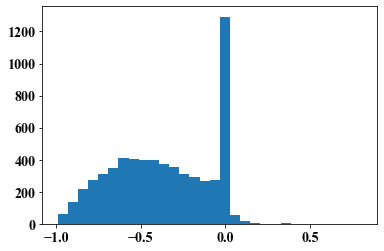

In [171]:
plt.figure()
plt.hist(edge_score, bins=30)
plt.show()

In [172]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from umap import UMAP
#fit_obj = LocallyLinearEmbedding(n_components=d, n_neighbors=7, method='ltsa')
fit_obj = Isomap(n_components=d, n_neighbors=10)

#fit_obj = UMAP(n_neighbors=100, min_dist=0.5, n_components=3, random_state=42)
embedding = fit_obj.fit_transform(X)

In [173]:
edge_score

array([-2.6954651e-02, -4.5943260e-04, -6.9587803e-01, ...,
       -6.3002205e-01,  9.8469257e-03,  2.1093369e-02], dtype=float32)

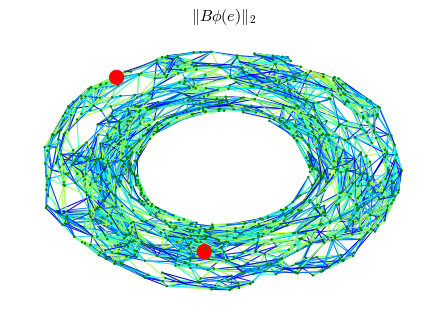

In [174]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

Bphi = B.dot(phi).reshape((W.shape[0],-1))
edge_color = np.linalg.norm(Bphi, axis=1)
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.jet,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)
plt.title('$\left\\|B\\phi(e)\\right\\|_2$')
plt.show()

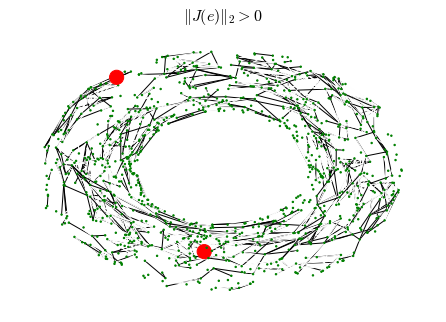

In [178]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

edge_color = (np.linalg.norm(J_opt, axis=1) > 0).astype('float32')
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)
plt.title('$\left\\|J(e)\\right\\|_2> 0$')
plt.show()

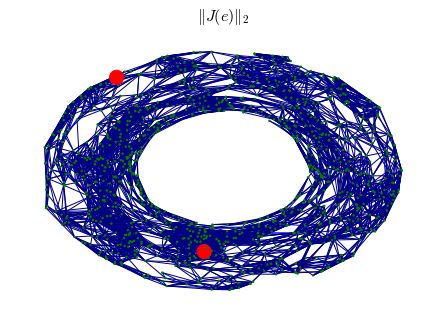

In [179]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

#edge_color = (np.linalg.norm(J_opt, axis=1) > 0).astype('float32')
# edge_color = np.concatenate([J_opt[:,0:1]/np.max(J_opt[:,0:1]),
#                              J_opt[:,1:2]/np.max(J_opt[:,1:2]),
#                              J_opt[:,0:1]*0.1,  J_opt[:,0:1]*0+1], axis=1)
edge_color = np.linalg.norm(J_opt, axis=1)
edge_color = edge_color/np.max(edge_color)

options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "with_labels": False,
    "edge_cmap": plt.cm.jet
}
nx.draw(CG, pos=pos, node_size=node_size, **options)
plt.title('$\left\\|J(e)\\right\\|_2$')
plt.show()

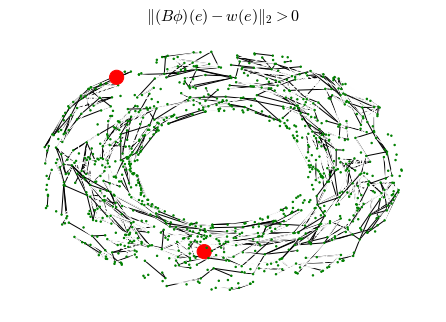

In [180]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

edge_color = (edge_score > 0).astype('float32')
    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.binary,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)
plt.title('$\left\\|(B\\phi)(e) - w(e)\\right\\|_2> 0$')
plt.show()

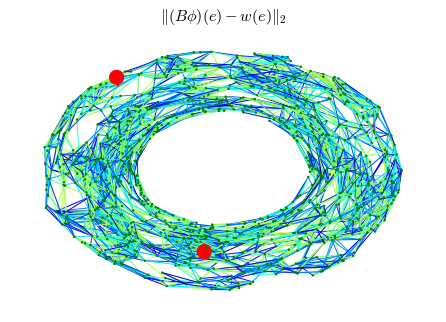

In [183]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]
    
node_size = np.ones(n)*2
node_size[source] = 200
node_size[dest] = 200
node_color = ['g']*n
node_color[source] = "r"
node_color[dest] = "r"

edge_color = edge_score/np.max(edge_color)

    
options = {
    "node_color": node_color,
    "edge_color": edge_color,
    "width": 1,
    "edge_cmap": plt.cm.jet,
    "with_labels": False,
}
nx.draw(CG, pos=pos, node_size=node_size, **options)
plt.title('$\left\\|(B\\phi)(e) - w(e)\\right\\|_2$')
plt.show()